# Uczenie maszynowe: Lab3

In [3]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.exceptions import ConvergenceWarning
from sklearn.ensemble import GradientBoostingClassifier
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif
from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import load_digits

### Analiza modelu klasyfikacyjnego
* wziąć konkretne dane, podzielić na część treningową i testową lub uczyć wg. schematu walidacji
krzyżowej
* sprawdzić jakie są hiperparametry danego modelu i znaleźć optymalne
* uczyć parametry modelu z danych, po skończonej nauce je wypisać

#### Walidacja krzyżowa
Techniką używana do oceny skuteczności modelu uczenia maszynowego poprzez podzielenie danych na wiele podzbiorów (foldów). Pozwala na uzyskanie bardziej wiarygodnych ocen wydajności modelu, minimalizując ryzyko overfittingu oraz underfittingu
- Overfitting: model zbyt dobrze dopasowany do danych treningowych, ale słabo generalizujący (model jest zbyt skomplikowany i ma zbyt wiele parametrów w stosunku do liczby dostępnych danych)
- Underfitting: model słabo dopasowany do danych treningowych, słabo generalizujący (model jest zbyt prosty, aby uchwycić podstawowe wzorce w danych)
- Uśrednianie wyników: w kontekście walidacji krzyżowej oznacza, że po przeprowadzeniu wielu iteracji trenowania i testowania modelu na różnych podzbiorach danych, wyniki uzyskane w każdej iteracji są łączone i obliczana jest ich średnia. Proces ten zapewnia bardziej stabilną i wiarygodną ocenę wydajności modelu

In [ ]:
warnings.filterwarnings('ignore', category=ConvergenceWarning) # ignorowanie ostrzeżeń o braku zbieżności

data = load_digits()

X = data.data # features (cechy) -> używane do trenowania modelu
y = data.target # etykiety -> wartości, które chcemy przewidzieć

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # test_size -> 80% training and 20% test
# random_state = 42 (służy jako ziarne losowości, aby wyniki były powtarzalne), natomiast jak wartość jest ta sama za każdym razem
# to mamy ten sam podział

# dane testowe 
print ("\nX_test = ", X_test.shape) # (próbki, cechy)
print ("Y_test = ", y_test.shape,) # (próbki, )
# dane treningowe 
print ("X_train = ", X_train.shape)
print ("Y_train = ", y_train.shape)

# Walidacja krzyżowa k - fold
# Dzielimy na k równych podzbiorów (w których każdy z podzbiorów raz występuje jako zbiór uczący, a pozostała, połączona 
# część zbioru jest wykorzystywana jako zbiór testowy)

# czyli dla k = 5, mamy 5 iteracji gdzie będziemy mieli podział na (w każdej iteracji) np. 4/5 zbioru treningowego i 1/5 zbioru testowego
# na koniec wyniki są uśredniane

k = 5
cv = StratifiedKFold(n_splits=k) # -> schemat walidacji krzyżowej

In [ ]:
def evaluate_model(X_train, X_test, Y_train, Y_test, model, param_grid, cv):
    cross_val_scores = cross_val_score(model, X_train, Y_train, cv=cv, scoring='accuracy') # metryka oceny -> dokładność
    # zwraca wyniki walidacji krzyżowej dla każdej iteracji

    # Walidacja krzyżowa - technika trenowania i testowania modelu na różnych podzbiorach danych
    # Dostajemy procentowo jak dobrze model działa tzn jaka jest dokładność
    # na danym podzbiorze danych
    print("\nWyniki walidacji krzyżowej: \n", cross_val_scores)
    print("Średni wynik walidacji krzyżowej: ", cross_val_scores.mean()) 

    # Grid Search -> wyszukanie najlepszych hiperparametrów
    # GridSearchCV przeprowadza przeszukiwanie siatki hiperparametrów na danych treningowych.
    # estimator=model określa, który model jest trenowany.
    # param_grid zawiera siatkę hiperparametrów do przetestowania
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='accuracy')
    grid_search.fit(X_train, Y_train)

    # Najlepsze hiperparametry
    best_params = grid_search.best_params_
    print(f"Najlepsze hiperparametry: {best_params}")

    # Trenowanie modelu z najlepszymi hiperparametrami
    best_model = grid_search.best_estimator_
    best_model.fit(X_train, Y_train) # trenowanie modelu z najlepszymi hiperparametrami

    # Predykcje i ocena na zbiorze testowym
    y_pred = best_model.predict(X_test) # Model z najlepszymi hiperparametrami dokonuje predykcji na zbiorze testowym

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Dokładność na zbiorze testowym: {accuracy:.4f}")
    print("Raport klasyfikacji:\n", classification_report(y_test, y_pred, zero_division=0)) 
    # raport klaasyfikacji -> precision, recall, f1-score

    # Wypisanie końcowych parametrów modelu
    print("Końcowe parametry modelu:")
    print(best_model.get_params())

### 1. Naiwny klasyfikator Bayesa
Prosty, ale potężny algorytm uczenia maszynowego stosowany głównie do problemów klasyfikacji. Nazwa "naiwny" pochodzi od założenia, że wszystkie cechy (atrybuty) w zbiorze danych są niezależne od siebie, co rzadko jest prawdą w rzeczywistych zastosowaniach.

In [ ]:
model = GaussianNB()
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]  # Dodaje niewielką wartość do wariancji, aby zapobiec dzieleniu przez zero
}

evaluate_model(X_train, X_test, y_train, y_test, model, param_grid, cv)

### 2. Model kNN (model k najbliższych sąsiadów)
Ma za zadnie znaleźć k sąsiadów, do których klasyfikowane obiekty są najbliższe dla wybranej metryki (np. Euklidesa), a następnie określa
wynik klasyfikacji na podstawie większości głosów tych najbliższych k sąsiadów, biorąc pod uwagę, która klasa jest reprezentowana największą liczbę razy w grupie k najbliższych sąsiadów

In [ ]:
model = KNeighborsClassifier()
param_grid = {
    'n_neighbors': [3, 5, 7, 9], # Liczba najbliższych sąsiadów
    'weights': ['uniform', 'distance'], # Waga dla sąsiadów, uniform - wszyscy sąsiedzi mają taką samą wagę, distance - im bliżej tym większa waga
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], # Algorytm używany do wyszukiwania najbliższych sąsiadów.
    'metric': ['euclidean', 'manhattan', 'minkowski'] # Metryka używana do obliczania odległości
}

# Poprawia wydajność modeli wrażliwych na skalowanie danych
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) # oblicza średnią i odchylenie standardowe na zbiorze treningowym i przekształca dane treningowe
# tak aby miały średnią 0 i wariancję 1
X_test = scaler.transform(X_test) # przekształca dane testowe

evaluate_model(X_train, X_test, y_train, y_test, model, param_grid, cv)

### 3. Drzewo decyzyjne
Model drzewa decyzyjnego jest strukturą drzewa, gdzie węzły reprezentują decyzje na podstawie wartości cech, a gałęzie przedstawiają możliwe wyniki tych decyzji. Liście drzewa reprezentują klasy (w przypadku klasyfikacji) lub wartości przewidywane (w przypadku regresji).

#### Jak działa drzewo decyzyjne?
##### Budowanie drzewa:

- Algorytm zaczyna od całego zbioru danych jako korzenia drzewa.
- W każdym węźle wybiera najlepszą cechę i wartość progu do podziału danych, maksymalizując czystość podzbiorów po podziale.
- Proces ten jest rekurencyjnie powtarzany dla każdego podzbioru, tworząc gałęzie drzewa, aż do spełnienia kryterium zatrzymania (np. maksymalna głębokość drzewa, minimalna liczba próbek w liściu).
Czystość podzbiorów:

#### Czystość podzbiorów 
- Po podziale jest oceniana za pomocą miar takich jak indeks Giniego czy entropia. Celem jest maksymalizacja czystości podzbiorów, tj. dążenie do sytuacji, gdzie podzbiory zawierają próbki głównie jednej klasy.

In [ ]:
model = DecisionTreeClassifier()
param_grid = {
    'criterion': ['gini', 'entropy'], # Kryterium oceny jakości podziału. indeks Giniego/Entropia (używa entropii do oceny czystości podziału)
    'max_depth': [None, 10, 20, 30], # Maksymalna głębokość drzewa, None - brak ograniczenia
    'min_samples_split': [2, 5, 10], # Minimalna liczba próbek wymagana do podziału węzła
    'min_samples_leaf': [1, 2, 4], # Minimalna liczba próbek wymagana w liściu węzła
    'splitter': ['best', 'random'], # Strategia podziału węzła 'best' - najlepszy podział, 'random' - losowy podział
    'max_features': ['sqrt', 'log2'], # Maksymalna liczba cech branych pod uwagę przy poszukiwaniu najlepszego podziału
}

evaluate_model(X_train, X_test, y_train, y_test, model, param_grid, cv)

### 4. Regresja logistyczna
Algorytmem klasyfikacyjnym, który jest używany do przewidywania binarnych wyników (0 lub 1). Model ten oblicza prawdopodobieństwo przynależności próbki do określonej klasy, stosując funkcję logistyczną (sigmoidę).

In [ ]:
model = LogisticRegression(max_iter=1000) # max_iter - maksymalna liczba iteracji
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100], # Odwrotność siły regularyzacji, mniejsza wartość oznacza silniejszą regularyzację
    'solver': ['liblinear', 'saga'], # Algorytm używany do optymalizacji
    # 'penalty': ['l1', 'l2', 'elasticnet'], # Rodzaj regularyzacji (None - break regularyzacji)
}

# Poprawia wydajność modeli wrażliwych na skalowanie danych
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

evaluate_model(X_train, X_test, y_train, y_test, model, param_grid, cv)

### 5. Model LDA (Linear Discriminant Analysis)
Jest to technika stosowana w statystyce, rozpoznawaniu wzorców i uczeniu maszynowym do znajdowania liniowej kombinacji cech, która najlepiej oddziela dwie lub więcej klas.

In [ ]:
model = LinearDiscriminantAnalysis()
param_grid = [
    {'solver': ['svd']},
    {'solver': ['lsqr', 'eigen'], 'shrinkage': ['auto', 0.1, 0.5, 1.0]}
]

evaluate_model(X_train, X_test, y_train, y_test, model, param_grid, cv)

### 6. Model MLP (Prosta sieć neuronowa)
Jest rodzajem sztucznej sieci neuronowej stosowanej w uczeniu nadzorowanym do rozwiązywania problemów klasyfikacyjnych. Jest to pełnoprawny klasyfikator, który uczy się na podstawie danych wejściowych i dostarcza predykcje klas.

In [ ]:
model = MLPClassifier(max_iter=100)
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)], # Wiele warstw ukrytych
    'activation': ['tanh', 'relu'], # Funkcja aktywacji dla warstw ukrytych
    'solver': ['sgd', 'adam'], # Optymalizator
    'alpha': [0.0001, 0.1], # Parametr regularyzacji (L2)
    'learning_rate': ['constant', 'adaptive'], # Plan uczenia
}

# Poprawia wydajność modeli wrażliwych na skalowanie danych
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

evaluate_model(X_train, X_test, y_train, y_test, model, param_grid, cv)

### 7. Model SVM (Support Vector Machine)
Algorytm uczenia maszynowego używany głównie do zadań klasyfikacyjnych, ale może być również stosowany do regresji (Support Vector Regression). SVM znajduje hiperpłaszczyznę, która najlepiej rozdziela dane w przestrzeni cech.

In [ ]:
model = SVC()
param_grid = {
    'C': [0.1, 1, 10, 100], # Parametr regularyzacji. Kontroluje kompromis między maksymalizacją marginesu a minimalizacją błędu klasyfikacji.
    'gamma': [1, 0.1, 0.01, 0.001], # Parametr funkcji jądrowej RBF (Radial Basis Function). 
    # Wyższa wartość oznacza większy wpływ próbek treningowych.
    'kernel': ['linear', 'rbf'] # Funkcja jądrowa
}

# Poprawia wydajność modeli wrażliwych na skalowanie danych
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

evaluate_model(X_train, X_test, y_train, y_test, model, param_grid, cv)

### 8. Bagging
Metoda zespołowa (ensemble), która poprawia stabilność i dokładność algorytmów uczenia maszynowego poprzez zmniejszenie wariancji. Metoda polega na trenowaniu wielu modeli bazowych na różnych losowo wybranych podzbiorach danych treningowych, a następnie łączeniu ich predykcji.

In [ ]:
base_model = DecisionTreeClassifier()
model = BaggingClassifier(estimator=base_model, random_state=42) # defaultowo estimator to DecisionTreeClassifier
param_grid = {
    'n_estimators': [50, 100, 10], # Liczba modeli bazowych (drzew decyzyjnych) w ensemble.
    'max_features': [0.5, 0.7, 1.0], # Maksymalna liczba cech branych pod uwagę przy poszukiwaniu najlepszego podziału
    'max_samples': [0.5, 1.0], # Liczba próbek używanych do trenowania każdego modelu bazowego
    'bootstrap': [True, False], # Czy próbki są losowane z powtórzeniami
    'bootstrap_features': [True, False], # Czy cechy są losowane z powtórzeniami
}

# Poprawia wydajność modeli wrażliwych na skalowanie danych
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
evaluate_model(X_train, X_test, y_train, y_test, model, param_grid, cv)

### 9. Boosting
Technika zespołowa, która tworzy silny model predykcyjny poprzez łączenie słabych modeli bazowych, zwykle drzew decyzyjnych. Metoda ta działa iteracyjnie, poprawiając błędy poprzednich modeli.

In [ ]:
model = GradientBoostingClassifier()
param_grid = {
    'n_estimators': [50, 100, 200], # Liczba drzew decyzyjnych
    'learning_rate': [0.01, 0.1], # Współczynnik uczenia
    'max_depth': [3, 5, 7], # Maksymalna głębokość drzewa
}

# Poprawia wydajność modeli wrażliwych na skalowanie danych
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
evaluate_model(X_train, X_test, y_train, y_test, model, param_grid, cv)

### 10. Lasy losowe
Metoda zespołowa (ensemble) polegająca na budowie wielu drzew decyzyjnych podczas treningu i wyjściu klasy będącej trybem klas (dla klasyfikacji) lub średnią predykcji (dla regresji) poszczególnych drzew. Random forest łączy prostotę drzew decyzyjnych z możliwościami agregacji w celu uzyskania lepszej wydajności i stabilności predykcji.

In [ ]:
model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],  # Liczba drzew w lesie
    'max_features': ['sqrt', 'log2'],  # Liczba cech do rozważenia przy podziale
    'max_depth': [None, 10, 20, 30],  # Maksymalna głębokość drzew
    'min_samples_split': [2, 5],  # Minimalna liczba próbek potrzebnych do podziału węzła
    'min_samples_leaf': [1, 2, 4],  # Minimalna liczba próbek w liściu
    'bootstrap': [True, False]  # Czy losować próbki z powtórzeniami
}

# Poprawia wydajność modeli wrażliwych na skalowanie danych
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
evaluate_model(X_train, X_test, y_train, y_test, model, param_grid, cv)

### Uczenie nienadzorowane
To jeden z głównych typów uczenia maszynowego, gdzie model jest trenowany na danych, które nie mają zdefiniowanych etykiet. Innymi słowy, nie dostarczamy modelowi przykładów, które wskazują, jakie powinny być wyniki (brak z góry określonych odpowiedzi). Celem uczenia nienadzorowanego jest odkrycie ukrytych struktur, wzorców lub zależności w danych.

### 11. Klasteryzacja (różne algorytmy)
Technika uczenia maszynowego, która polega na grupowaniu danych w taki sposób, aby obiekty w tych samych grupach (klastrach) były do siebie bardziej podobne niż obiekty w różnych grupach. Jest to metoda uczenia nienadzorowanego, co oznacza, że model nie korzysta z etykiet ani kategorii podczas procesu grupowania

KMeans Silhouette Score: 0.6621


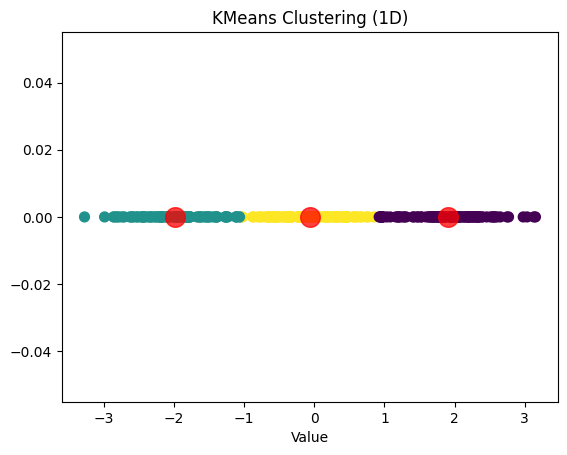

Hierarchical Clustering Silhouette Score: 0.6302


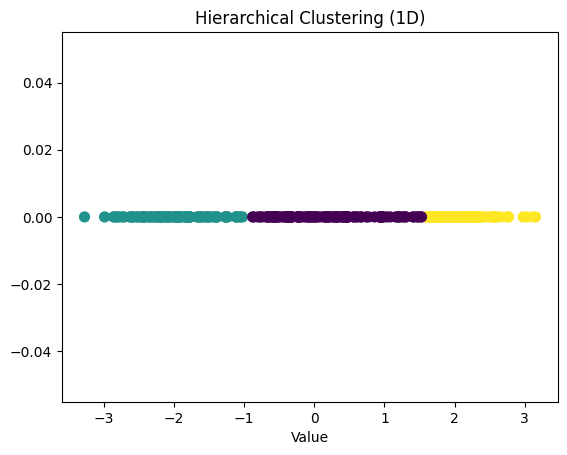

KMeans Silhouette Score: 0.6820


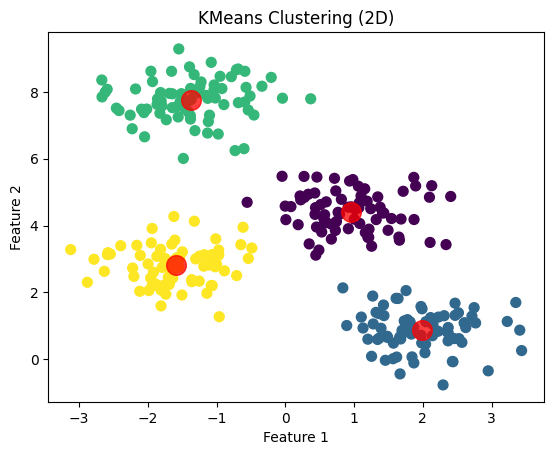

Hierarchical Clustering Silhouette Score: 0.6820


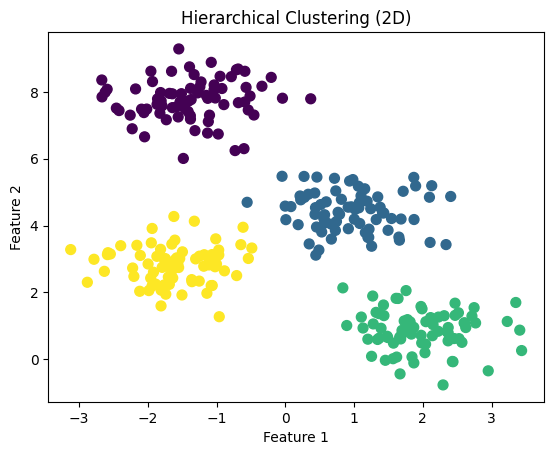

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Generowanie danych 1D za pomocą make_blobs
def generate_1d_data():
    X, _ = make_blobs(n_samples=300, centers=[[-2], [0], [2]], cluster_std=0.5, random_state=0)
    return X

# Generowanie danych 2D za pomocą make_blobs
def generate_2d_data():
    X, _ = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)
    return X

# KMeans klasteryzacja
def kmeans_clustering(X, n_clusters=3):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)  # Tworzenie instancji modelu KMeans
    labels = kmeans.fit_predict(X)  # Dopasowanie modelu i przewidywanie klastrów
    score = silhouette_score(X, labels)  # Obliczanie wskaźnika Silhouette
    print(f"KMeans Silhouette Score: {score:.4f}")  # Wyświetlanie wskaźnika Silhouette
    return labels, kmeans.cluster_centers_  # Zwracanie etykiet klastrów i centrów klastrów

# Hierarchical Clustering
def hierarchical_clustering(X, n_clusters=3):
    hierarchical = AgglomerativeClustering(n_clusters=n_clusters)  # Tworzenie instancji modelu Hierarchical Clustering
    labels = hierarchical.fit_predict(X)  # Dopasowanie modelu i przewidywanie klastrów
    score = silhouette_score(X, labels)  # Obliczanie wskaźnika Silhouette
    print(f"Hierarchical Clustering Silhouette Score: {score:.4f}")  # Wyświetlanie wskaźnika Silhouette
    return labels  # Zwracanie etykiet klastrów

# Wizualizacja klasteryzacji dla danych 1D
def plot_1d_clustering(X, labels, centers, title):
    plt.scatter(X, np.zeros_like(X), c=labels, cmap='viridis', s=50)  # Rysowanie punktów danych
    if centers is not None:
        plt.scatter(centers, np.zeros_like(centers), c='red', s=200, alpha=0.75)  # Rysowanie centrów klastrów
    plt.title(title)  # Tytuł wykresu
    plt.xlabel('Value')  # Etykieta osi X
    plt.show()  # Wyświetlanie wykresu

# Wizualizacja klasteryzacji dla danych 2D
def plot_2d_clustering(X, labels, centers, title):
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50)  # Rysowanie punktów danych
    if centers is not None:
        plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75)  # Rysowanie centrów klastrów
    plt.title(title)  # Tytuł wykresu
    plt.xlabel('Feature 1')  # Etykieta osi X
    plt.ylabel('Feature 2')  # Etykieta osi Y
    plt.show()  # Wyświetlanie wykresu

# Klasteryzacja i wizualizacja dla danych 1D
def clustering_1d():
    X = generate_1d_data()  # Generowanie danych 1D

    # KMeans
    labels, centers = kmeans_clustering(X, n_clusters=3)  # Klasteryzacja KMeans
    plot_1d_clustering(X, labels, centers, 'KMeans Clustering (1D)')  # Wizualizacja wyników KMeans

    # Hierarchical Clustering
    labels = hierarchical_clustering(X, n_clusters=3)  # Klasteryzacja Hierarchical Clustering
    plot_1d_clustering(X, labels, None, 'Hierarchical Clustering (1D)')  # Wizualizacja wyników Hierarchical Clustering

# Klasteryzacja i wizualizacja dla danych 2D
def clustering_2d():
    X = generate_2d_data()  # Generowanie danych 2D

    # KMeans
    labels, centers = kmeans_clustering(X, n_clusters=4)  # Klasteryzacja KMeans
    plot_2d_clustering(X, labels, centers, 'KMeans Clustering (2D)')  # Wizualizacja wyników KMeans

    # Hierarchical Clustering
    labels = hierarchical_clustering(X, n_clusters=4)  # Klasteryzacja Hierarchical Clustering
    plot_2d_clustering(X, labels, None, 'Hierarchical Clustering (2D)')  # Wizualizacja wyników Hierarchical Clustering

# Uruchomienie klasteryzacji
clustering_1d()  # Klasteryzacja i wizualizacja dla danych 1D
clustering_2d()  # Klasteryzacja i wizualizacja dla danych 2D

### 12. Szacowanie gęstości rozkładu (kernel density estimation)
Kernel Density Estimation (KDE) jest zaawansowaną metodą, która pozwala na gładkie i dokładne oszacowanie gęstości rozkładu danych, w przeciwieństwie do bardziej podstawowych metod, takich jak histogramy. 

Najlepsze hiperparametry (1D): {'bandwidth': 0.24210526315789474}


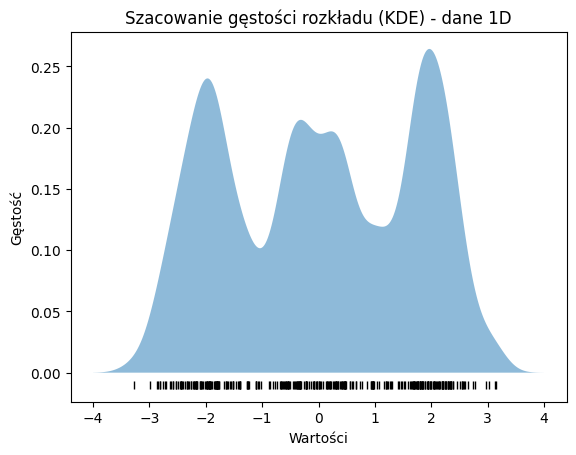

Najlepsze hiperparametry (2D): {'bandwidth': 0.33684210526315794}


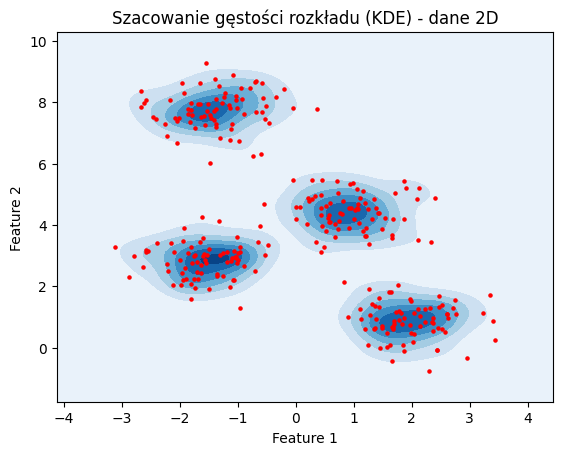

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_blobs

# Szacowanie gęstości rozkładu w 1D
def kde_1d():
    # Generowanie danych 1D za pomocą make_blobs
    # każdy klaster ma odchylenie standardowe = 0.5
    # 3 różne klastry centers = ...
    X, _ = make_blobs(n_samples=300, centers=[[-2], [0], [2]], cluster_std=0.5, random_state=0)

    # Definicja siatki hiperparametrów
    param_grid = {
        'bandwidth': np.linspace(0.1, 1.0, 20),  # Zmniejszenie liczby punktów w siatce
    }

    # Tworzenie modelu KDE
    kde = KernelDensity()

    # Dopasowanie modelu GridSearchCV do znalezienia najlepszych hiperparametrów
    grid_search = GridSearchCV(kde, param_grid, cv=5)
    grid_search.fit(X)

    # Najlepsze hiperparametry
    best_params = grid_search.best_params_
    print(f"Najlepsze hiperparametry (1D): {best_params}")

    # Dopasowanie modelu KDE z najlepszymi hiperparametrami
    kde = KernelDensity(**best_params)
    kde.fit(X)

    # Generowanie próbek
    X_d = np.linspace(-4, 4, 1000)[:, np.newaxis]
    log_dens = kde.score_samples(X_d)

    # Wizualizacja szacowania gęstości
    plt.fill_between(X_d[:, 0], np.exp(log_dens), alpha=0.5)
    plt.plot(X[:, 0], np.full_like(X[:, 0], -0.01), '|k', markeredgewidth=1)
    plt.title("Szacowanie gęstości rozkładu (KDE) - dane 1D")
    plt.xlabel("Wartości")
    plt.ylabel("Gęstość")
    plt.show()

# Szacowanie gęstości rozkładu w 2D
def kde_2d():
    # Generowanie danych 2D
    X, _ = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)

    # Definicja siatki hiperparametrów
    param_grid = {
        'bandwidth': np.linspace(0.1, 1.0, 20),  # Zmniejszenie liczby punktów w siatce
    }

    # Tworzenie modelu KDE
    kde = KernelDensity()

    # Dopasowanie modelu GridSearchCV do znalezienia najlepszych hiperparametrów
    grid_search = GridSearchCV(kde, param_grid, cv=5)
    grid_search.fit(X)

    # Najlepsze hiperparametry
    best_params = grid_search.best_params_
    print(f"Najlepsze hiperparametry (2D): {best_params}")

    # Dopasowanie modelu KDE z najlepszymi hiperparametrami
    kde = KernelDensity(**best_params)
    kde.fit(X)

    # Generowanie siatki punktów do wizualizacji
    x = np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 100)
    y = np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 100)
    X_grid, Y_grid = np.meshgrid(x, y)
    grid_points = np.vstack([X_grid.ravel(), Y_grid.ravel()]).T

    # Obliczanie gęstości na siatce punktów
    log_dens = kde.score_samples(grid_points)
    dens = np.exp(log_dens).reshape(X_grid.shape)

    # Wizualizacja szacowania gęstości
    plt.contourf(X_grid, Y_grid, dens, cmap='Blues')
    plt.scatter(X[:, 0], X[:, 1], c='red', s=5)
    plt.title("Szacowanie gęstości rozkładu (KDE) - dane 2D")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

# Wykonanie funkcji
kde_1d()
kde_2d()

### Inżynieria cech
Inżynieria cech to proces przekształcania danych w celu poprawy wydajności modeli uczenia maszynowego. Obejmuje to zarówno redukcję wymiarowości (np. metodą PCA), jak i selekcję cech, aby wybrać najbardziej informacyjne cechy.

#### Selekcja cech (różne algorytmy).
Selekcja cech polega na wyborze podzbioru cech, które są najbardziej istotne dla danego problemu predykcyjnego. Można to zrobić na różne sposoby, np. na podstawie znaczenia cech określonego przez model lub poprzez univariate selection, gdzie każda cecha jest oceniana indywidualnie.
- Celem jest zredukowanie liczby cech do tych, które są najbardziej informatywne i istotne dla modelu, co może prowadzić do poprawy jego wydajności, uproszczenia modelu i zmniejszenia ryzyka przeuczenia (overfitting).

In [8]:
warnings.filterwarnings('ignore', category=ConvergenceWarning)
# Dane
data = load_digits()

X = data.data 
y = data.target 

# Trenowanie modelu
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standaryzacja danych
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Tworzenie modelu Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Trening modelu bez selekcji cech
model = SVC(kernel='linear', random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Dokładność na zbiorze testowym (bez selekcji): {accuracy:.4f}")
print("Raport klasyfikacji (bez selekcji):\n", classification_report(y_test, y_pred))

# Selekcja cech na podstawie znaczenia cech
selector = SelectFromModel(rf, prefit=True) # wybiera cechy, które mają znaczenie # prefit = True, ponieważ model jest już wytrenowany
X_train_rf = selector.transform(X_train)
X_test_rf = selector.transform(X_test)

# Trening modelu z selekcją cech (znaczenie cech)
model.fit(X_train_rf, y_train)
y_pred_rf = model.predict(X_test_rf)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Dokładność na zbiorze testowym (znaczenie cech): {accuracy_rf:.4f}")
print("Raport klasyfikacji (znaczenie cech):\n", classification_report(y_test, y_pred_rf))

# Wybieranie najlepszych cech za pomocą testu ANOVA
# k - liczba cech do wybrania
# score_func - funkcja oceny cech
selector = SelectKBest(score_func=f_classif, k=2) #  wybiera k cech, które mają najwyższe wyniki dla wybranego testu statystycznego, 
# mierząc ich zależność z docelową zmienną
X_train_best = selector.fit_transform(X_train, y_train)
X_test_best = selector.transform(X_test)

# Trenowanie modelu po selekcji cech
model.fit(X_train_best, y_train)
y_pred_best = model.predict(X_test_best)
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"Dokładność na zbiorze testowym (Univariate Selection): {accuracy_best:.4f}")
print("Raport klasyfikacji (Univariate Selection):\n", classification_report(y_test, y_pred_best))

Dokładność na zbiorze testowym (bez selekcji): 0.9750
Raport klasyfikacji (bez selekcji):
               precision    recall  f1-score   support

           0       0.97      1.00      0.99        33
           1       0.97      1.00      0.98        28
           2       1.00      1.00      1.00        33
           3       0.94      0.97      0.96        34
           4       1.00      1.00      1.00        46
           5       0.96      0.96      0.96        47
           6       0.97      0.97      0.97        35
           7       0.97      0.97      0.97        34
           8       1.00      0.93      0.97        30
           9       0.97      0.95      0.96        40

    accuracy                           0.97       360
   macro avg       0.98      0.98      0.98       360
weighted avg       0.98      0.97      0.97       360

Dokładność na zbiorze testowym (znaczenie cech): 0.9694
Raport klasyfikacji (znaczenie cech):
               precision    recall  f1-score   support



c:\Studia_repo_uczenie_maszynowe\env\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 0 32 39] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Studia_repo_uczenie_maszynowe\env\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


### Redukcja wymiarowości: Metoda PCA
Principal Component Analysis (PCA) to statystyczna metoda analizy danych, która przekształca dane o wysokiej wymiarowości na dane o mniejszej liczbie wymiarów. Celem PCA jest zredukowanie liczby wymiarów przy jednoczesnym zachowaniu jak największej ilości informacji zawartej w oryginalnych danych.
- PCA może prowadzić do mniejszej dokładności modelu w porównaniu do modelu trenowanego bez redukcji wymiarowości. Dzieje się tak dlatego, że PCA zmniejsza liczbę cech, co może skutkować utratą istotnych informacji zawartych w danych. W niektórych przypadkach, szczególnie jeśli liczba wybranych komponentów jest zbyt mała, model może nie być w stanie uchwycić wszystkich istotnych wzorców w danych.

In [7]:
# Wczytywanie danych
data = load_digits()

X = data.data 
y = data.target 

# Podział danych na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standaryzacja danych -> każda zmienna ma średnią 0 i wariancję 1 aby zmienne występujące w zbiorze danych były tej samej skali
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Trenowanie modelu bez redukcji wymiarowości
# 100 drzew decyzyjnych
model = RandomForestClassifier(n_estimators=100, random_state=42)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Dokładność na zbiorze testowym (bez redukcji): {accuracy:.4f}")
print("Raport klasyfikacji (bez redukcji):\n", classification_report(y_test, y_pred))

# Redukcja wymiarowości za pomocą PCA
pca = PCA(n_components=2) # redukuje do 2 składowych głównych
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

model.fit(X_train_pca, y_train)
y_pred_pca = model.predict(X_test_pca)
accuracy_pca = accuracy_score(y_test, y_pred_pca)
print(f"\nDokładność na zbiorze testowym (PCA): {accuracy_pca:.4f}")
print("Raport klasyfikacji (PCA):\n", classification_report(y_test, y_pred_pca))

Dokładność na zbiorze testowym (bez redukcji): 0.9722
Raport klasyfikacji (bez redukcji):
               precision    recall  f1-score   support

           0       1.00      0.97      0.98        33
           1       0.97      1.00      0.98        28
           2       1.00      1.00      1.00        33
           3       1.00      0.94      0.97        34
           4       0.98      1.00      0.99        46
           5       0.94      0.96      0.95        47
           6       0.97      0.97      0.97        35
           7       0.97      0.97      0.97        34
           8       0.97      0.97      0.97        30
           9       0.95      0.95      0.95        40

    accuracy                           0.97       360
   macro avg       0.97      0.97      0.97       360
weighted avg       0.97      0.97      0.97       360


Dokładność na zbiorze testowym (PCA): 0.5389
Raport klasyfikacji (PCA):
               precision    recall  f1-score   support

           0       0.